# 時系列クラスタ特徴量を追加して、XGB

# Amazon Forecast の Get Started サンプル（電力需要予測）を回帰問題としてXGBoostでモデル化する

https://docs.aws.amazon.com/ja_jp/forecast/latest/dg/gs-console.html

36時間後までを予測するため、36時間前の情報から予測する必要があります。

## 0.環境準備

In [2]:
import sys
print(sys.path)
sys.path.append('/usr/local/lib/python3.7/site-packages')
print('-------------------------------')
print(sys.path)

['/root/data/study-timeseries-analysis/AmazonForecast_vs_XGBoost/notebook', '/opt/.sagemakerinternal/conda/lib/python37.zip', '/opt/.sagemakerinternal/conda/lib/python3.7', '/opt/.sagemakerinternal/conda/lib/python3.7/lib-dynload', '', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython']
-------------------------------
['/root/data/study-timeseries-analysis/AmazonForecast_vs_XGBoost/notebook', '/opt/.sagemakerinternal/conda/lib/python37.zip', '/opt/.sagemakerinternal/conda/lib/python3.7', '/opt/.sagemakerinternal/conda/lib/python3.7/lib-dynload', '', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.7/site-packages']


In [3]:
pip freeze # condaの環境が出力される？

argcomplete==1.12.3
asn1crypto==0.24.0
async-generator==1.10
attrs==21.2.0
backcall==0.2.0
bleach==4.1.0
certifi==2021.10.8
cffi==1.12.2
chardet==3.0.4
colorama==0.4.4
conda==4.10.3
conda-package-handling==1.7.3
cryptography==2.6.1
debugpy==1.5.0
decorator==5.1.0
defusedxml==0.7.1
entrypoints==0.3
idna==2.8
importlib-metadata==4.8.1
ipykernel==6.4.1
ipython==7.28.0
ipython-genutils==0.2.0
jedi==0.18.0
Jinja2==3.0.2
jsonschema==4.1.0
jupyter-client==6.1.13
jupyter-core==4.8.1
jupyter-kernel-gateway==2.4.0
jupyter-telemetry==0.1.0
jupyterlab-pygments==0.1.2
MarkupSafe==2.0.1
matplotlib-inline==0.1.3
mistune==0.8.4
nb-conda-kernels==2.3.1
nbclient==0.5.4
nbconvert==6.2.0
nbformat==5.1.3
nest-asyncio==1.5.1
notebook==6.0.3
packaging==21.0
pandocfilters==1.5.0
parso==0.8.2
pexpect==4.8.0
pickleshare==0.7.5
prometheus-client==0.11.0
prompt-toolkit==3.0.20
psutil==5.8.0
ptyprocess==0.7.0
pycosat==0.6.3
pycparser==2.19
Pygments==2.10.0
pyOpenSSL==19.0.0
pyparsing==2.4.7
pyrsistent==0.18.0
PySo

In [4]:
!pip freeze # コンテナの環境が出力される

ansiwrap==0.8.4
argcomplete==1.12.3
argon2-cffi==21.1.0
attrs==21.2.0
backcall==0.2.0
black==21.9b0
bleach==4.1.0
boto3==1.19.2
botocore==1.22.2
certifi==2021.10.8
cffi==1.15.0
charset-normalizer==2.0.7
click==8.0.3
cycler==0.11.0
debugpy==1.5.1
decorator==5.1.0
defusedxml==0.7.1
entrypoints==0.3
idna==3.3
importlib-metadata==4.8.1
ipykernel==6.4.2
ipython==7.28.0
ipython-genutils==0.2.0
ipywidgets==7.6.5
jedi==0.18.0
Jinja2==3.0.2
jmespath==0.10.0
joblib==1.1.0
jsonschema==4.1.2
jupyter==1.0.0
jupyter-client==7.0.6
jupyter-console==6.4.0
jupyter-core==4.8.1
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.2
kiwisolver==1.3.2
lightgbm==3.3.0
MarkupSafe==2.0.1
matplotlib==3.4.3
matplotlib-inline==0.1.3
mistune==0.8.4
mypy-extensions==0.4.3
nbclient==0.5.4
nbconvert==6.2.0
nbformat==5.1.3
nest-asyncio==1.5.1
notebook==6.4.5
nteract-scrapbook==0.4.2
numpy==1.21.3
packaging==21.0
pandas==1.3.4
pandocfilters==1.5.0
papermill==2.3.3
parso==0.8.2
pathspec==0.9.0
pexpect==4.8.0
pickleshare==

## 1.データセット読み込み

In [5]:
import pandas as pd

In [6]:
#df = pd.read_csv('./electricityusage_20140101_20140630.csv', names=['date','demand','item_id'])
df = pd.read_csv('../input/electricityusagedata.zip', names=['date','demand','item_id'])

In [7]:
print(df.shape)
print(df['date'].min())
print(df['date'].max())
df.head()

(3241200, 3)
2014-01-01 01:00:00
2015-01-01 00:00:00


,date,demand,item_id
0,2014-01-01 01:00:00,2.538071,client_0
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2
3,2014-01-01 01:00:00,144.817073,client_3
4,2014-01-01 01:00:00,75.000000,client_4


In [9]:
df = df[df.date<'2014-07-03']

In [10]:
df['item_id'] = df['item_id'].str.replace('client_','').astype(int)

## 2.特徴量生成

### 1)時刻型に変換し、特徴量（時間帯、曜日）を抽出

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

In [12]:
df['num_of_week'] = df['date'].dt.dayofweek

In [13]:
df['hour'] = df['date'].dt.hour

In [14]:
df.head()

,date,demand,item_id,num_of_week,hour
0,2014-01-01 01:00:00,2.538071,0,2,1
1,2014-01-01 01:00:00,23.648649,1,2,1
2,2014-01-01 01:00:00,0.000000,2,2,1
3,2014-01-01 01:00:00,144.817073,3,2,1
4,2014-01-01 01:00:00,75.000000,4,2,1


### 2)clientごとに時間差の値を特徴量にもつ（48hより前である必要がある）

In [15]:
#df["before_36h"] = df.groupby(['item_id']).shift(36)['demand'].reset_index()['demand']
#df["before_37h"] = df.groupby(['item_id']).shift(37)['demand'].reset_index()['demand']
#df["before_38h"] = df.groupby(['item_id']).shift(38)['demand'].reset_index()['demand']
df["before_48h"] = df.groupby(['item_id']).shift(48)['demand'].reset_index()['demand']
df["before_72h"] = df.groupby(['item_id']).shift(72)['demand'].reset_index()['demand']
df["before_96h"] = df.groupby(['item_id']).shift(96)['demand'].reset_index()['demand']

### 3)clientごとに期間で集約する

In [16]:
df = df.sort_values(["item_id","date"]).reset_index()

In [17]:
df.head()

,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h
0,0,2014-01-01 01:00:00,2.538071,0,2,1,NaN,NaN,NaN
1,370,2014-01-01 02:00:00,2.855330,0,2,2,NaN,NaN,NaN
2,740,2014-01-01 03:00:00,2.855330,0,2,3,NaN,NaN,NaN
3,1110,2014-01-01 04:00:00,2.855330,0,2,4,NaN,NaN,NaN
4,1480,2014-01-01 05:00:00,2.538071,0,2,5,NaN,NaN,NaN


In [18]:
df['mean_24h'] = df.groupby(['item_id']).rolling(24)['demand'].mean().reset_index()['demand'] ### この値自体は利用しない
df['var_24h'] = df.groupby(['item_id']).rolling(24)['demand'].var().reset_index()['demand'] ### この値自体は利用しない
df['max_24h'] = df.groupby(['item_id']).rolling(24)['demand'].max().reset_index()['demand'] ### この値自体は利用しない
df['min_24h'] = df.groupby(['item_id']).rolling(24)['demand'].min().reset_index()['demand'] ### この値自体は利用しない

df['mean_48h'] = df.groupby(['item_id']).rolling(48)['demand'].mean().reset_index()['demand'] ### この値自体は利用しない
df['var_48h'] = df.groupby(['item_id']).rolling(48)['demand'].var().reset_index()['demand'] ### この値自体は利用しない
df['max_48h'] = df.groupby(['item_id']).rolling(48)['demand'].max().reset_index()['demand'] ### この値自体は利用しない
df['min_48h'] = df.groupby(['item_id']).rolling(48)['demand'].min().reset_index()['demand'] ### この値自体は利用しない

In [19]:
#df = df.sort_values(["client","timestamp"]).reset_index()
#df['mean_24h_before_36h'] = df.groupby(['client']).rolling(2)['demand'].mean().reset_index()['demand']

In [20]:
df["mean_24h_before_48h"] = df.groupby(['item_id']).shift(48)['mean_24h'].reset_index()['mean_24h']
df["var_24h_before_48h"] = df.groupby(['item_id']).shift(48)['var_24h'].reset_index()['var_24h']
df["max_24h_before_48h"] = df.groupby(['item_id']).shift(48)['max_24h'].reset_index()['max_24h']
df["min_24h_before_48h"] = df.groupby(['item_id']).shift(48)['min_24h'].reset_index()['min_24h']

df["mean_48h_before_48h"] = df.groupby(['item_id']).shift(48)['mean_48h'].reset_index()['mean_48h']
df["var_48h_before_48h"] = df.groupby(['item_id']).shift(48)['var_48h'].reset_index()['var_48h']
df["max_48h_before_48h"] = df.groupby(['item_id']).shift(48)['max_48h'].reset_index()['max_48h']
df["min_48h_before_48h"] = df.groupby(['item_id']).shift(48)['min_48h'].reset_index()['min_48h']



In [21]:
df[df.item_id==21].head()

,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h,...,max_48h,min_48h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h
92211,21,2014-01-01 01:00:00,29.887920,21,2,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92212,391,2014-01-01 02:00:00,28.953923,21,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92213,761,2014-01-01 03:00:00,28.953923,21,2,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92214,1131,2014-01-01 04:00:00,25.373599,21,2,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92215,1501,2014-01-01 05:00:00,23.661270,21,2,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df[df.item_id==21].tail()

,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h,...,max_48h,min_48h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h
96597,1622841,2014-07-02 19:00:00,26.151930,21,2,19,34.869240,18.524284,19.769614,28.480438,...,60.709838,10.585305,28.687993,219.327838,52.770859,9.495641,22.801863,156.054984,52.770859,9.028643
96598,1623211,2014-07-02 20:00:00,25.529265,21,2,20,34.402242,20.392279,21.793275,28.370174,...,60.709838,10.585305,29.271741,217.399815,52.770859,9.495641,23.064550,158.826033,52.770859,9.028643
96599,1623581,2014-07-02 21:00:00,23.661270,21,2,21,22.415940,20.859278,23.194271,28.415577,...,60.709838,10.585305,29.336602,216.362054,52.770859,9.495641,23.048334,158.834358,52.770859,9.028643
96600,1623951,2014-07-02 22:00:00,26.307597,21,2,22,22.727273,18.679950,25.840598,28.681507,...,60.709838,10.585305,29.505241,213.294075,52.770859,9.495641,22.983473,158.666366,52.770859,9.028643
96601,1624321,2014-07-02 23:00:00,25.373599,21,2,23,24.439601,23.972603,27.708593,28.765826,...,60.709838,10.585305,29.524699,213.078489,52.770859,9.495641,22.915369,158.231705,52.770859,9.028643


# クラスタ特徴量追加

In [23]:
df_lbl = pd.read_csv('../tsl/data/lbl.csv')

In [24]:
df_lbl

,item_id,label
0,client_0,1
1,client_1,0
2,client_10,1
3,client_100,0
4,client_101,1
...,...,...
365,client_95,2
366,client_96,2
367,client_97,0
368,client_98,0


In [25]:
df_lbl['item_id'] = df_lbl['item_id'].str.replace('client_','').astype(int)

In [26]:
df_lbl

,item_id,label
0,0,1
1,1,0
2,10,1
3,100,0
4,101,1
...,...,...
365,95,2
366,96,2
367,97,0
368,98,0


In [27]:
df = pd.merge(df, df_lbl, how='left', on=['item_id'])

In [28]:
df

,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h,...,min_48h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h,label
0,0,2014-01-01 01:00:00,2.538071,0,2,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,370,2014-01-01 02:00:00,2.855330,0,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,740,2014-01-01 03:00:00,2.855330,0,2,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1110,2014-01-01 04:00:00,2.855330,0,2,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1480,2014-01-01 05:00:00,2.538071,0,2,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624665,1623189,2014-07-02 19:00:00,24581.081081,369,2,19,20540.540541,20675.675676,20243.243243,21911.599099,...,17594.594595,18716.216216,1.290294e+06,20540.540541,16486.486486,19105.855856,1.673331e+06,21810.810811,16486.486486,2
1624666,1623559,2014-07-02 20:00:00,21513.513514,369,2,20,18972.972973,20027.027027,19243.243243,21783.220721,...,17594.594595,18672.297297,1.216443e+06,20540.540541,16486.486486,19100.225225,1.673273e+06,21810.810811,16486.486486,2
1624667,1623929,2014-07-02 21:00:00,23608.108108,369,2,21,21432.432432,19878.378378,18864.864865,21802.927928,...,17594.594595,18737.049550,1.480055e+06,21432.432432,16486.486486,19153.716216,1.784900e+06,21810.810811,16486.486486,2
1624668,1624299,2014-07-02 22:00:00,23851.351351,369,2,22,20540.540541,19770.270270,18635.135135,21807.432432,...,17594.594595,18769.144144,1.573982e+06,21432.432432,16486.486486,19193.412162,1.818490e+06,21810.810811,16486.486486,2


In [43]:
feature_col = [
    'item_id',
    'num_of_week',
    'hour',
    #'before_36h',
    #'before_37h',
    #'before_38h',
    'before_48h',
    'before_72h',
    'before_96h',
    'mean_24h_before_48h',
    'var_24h_before_48h',
    'max_24h_before_48h',
    'min_24h_before_48h',
    'mean_48h_before_48h',
    'var_48h_before_48h',
    'max_48h_before_48h',
    'min_48h_before_48h',
    'label'
]

## 3.データ分割
all:2014-01-01 01:00:00 〜 2015-01-01 00:00:00  
train:2014-01-01 01:00:00 〜 2014-12-29 00:00:00  
valid:2014-12-29 01:00:00 〜 2014-12-30 12:00:00(36h)  
test:2014-12-30 13:00:00 〜 2015-01-01 00:00:00(36h)  

In [30]:
#df_train = df[df.timestamp <= '2014-12-29 00:00:00']
df_train = df[df.date < '2014-06-29 00:00:00']

In [31]:
df_train.tail()

,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h,...,min_48h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h,label
1624569,1587669,2014-06-28 19:00:00,20243.243243,369,5,19,27337.837838,22378.378378,21851.351351,20557.432432,...,18243.243243,21203.265766,5.834542e+06,27337.837838,17608.108108,20702.984234,4.519073e+06,27337.837838,17364.864865,2
1624570,1588039,2014-06-28 20:00:00,19243.243243,369,5,20,24635.135135,19783.783784,23891.891892,20396.396396,...,18243.243243,21405.405405,6.216375e+06,27337.837838,17608.108108,20718.468468,4.631439e+06,27337.837838,17364.864865,2
1624571,1588409,2014-06-28 21:00:00,18864.864865,369,5,21,25310.810811,22594.594595,19608.108108,20212.274775,...,18243.243243,21518.581081,6.804662e+06,27337.837838,17608.108108,20837.274775,5.039507e+06,27337.837838,17364.864865,2
1624572,1588779,2014-06-28 22:00:00,18635.135135,369,5,22,22445.945946,22581.081081,17864.864865,20084.459459,...,18243.243243,21512.950450,6.792938e+06,27337.837838,17608.108108,20932.713964,4.897281e+06,27337.837838,17364.864865,2
1624573,1589149,2014-06-28 23:00:00,19175.675676,369,5,23,22729.729730,21364.864865,20054.054054,20042.792793,...,18243.243243,21569.819820,6.852982e+06,27337.837838,17608.108108,20988.457207,4.946389e+06,27337.837838,17364.864865,2


In [32]:
df_valid = df[(df.date >= '2014-06-29 00:00:00') & (df.date < '2014-07-01 00:00:00')]

In [33]:
print(df_valid.shape)
df_valid.head()

(17760, 26)


,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h,...,min_48h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h,label
4295,1589150,2014-06-29 00:00:00,1.269036,0,6,0,1.586294,1.586294,1.903553,0.793147,...,0.317259,1.361569,0.476826,2.85533,0.317259,1.269036,0.479709,3.172589,0.317259,1
4296,1589520,2014-06-29 01:00:00,1.269036,0,6,1,1.269036,1.269036,1.586294,0.779928,...,0.317259,1.361569,0.476826,2.85533,0.317259,1.262426,0.477523,3.172589,0.317259,1
4297,1589890,2014-06-29 02:00:00,1.269036,0,6,2,1.586294,1.269036,1.903553,0.766709,...,0.317259,1.374788,0.478467,2.85533,0.317259,1.255816,0.470964,3.172589,0.317259,1
4298,1590260,2014-06-29 03:00:00,1.269036,0,6,3,1.586294,1.269036,1.903553,0.766709,...,0.317259,1.388008,0.479744,2.85533,0.317259,1.249207,0.464316,3.172589,0.317259,1
4299,1590630,2014-06-29 04:00:00,1.269036,0,6,4,1.586294,1.269036,1.903553,0.766709,...,0.317259,1.401227,0.480655,2.85533,0.317259,1.242597,0.457579,3.172589,0.317259,1


In [34]:
df_valid.tail()

,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h,...,min_48h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h,label
1624617,1605429,2014-06-30 19:00:00,20540.540541,369,0,19,20243.243243,26081.081081,27337.837838,18716.216216,...,16486.486486,20557.432432,1.887037e+06,23418.918919,18243.243243,21150.056306,2.963308e+06,26081.081081,18243.243243,2
1624618,1605799,2014-06-30 20:00:00,18972.972973,369,0,20,19243.243243,23108.108108,24635.135135,18672.297297,...,16486.486486,20396.396396,1.652200e+06,23418.918919,18243.243243,21037.725225,2.769361e+06,26081.081081,18243.243243,2
1624619,1606169,2014-06-30 21:00:00,21432.432432,369,0,21,18864.864865,23283.783784,25310.810811,18737.049550,...,16486.486486,20212.274775,1.356329e+06,23418.918919,18243.243243,20903.434685,2.462902e+06,26081.081081,18243.243243,2
1624620,1606539,2014-06-30 22:00:00,20540.540541,369,0,22,18635.135135,21702.702703,22445.945946,18769.144144,...,16486.486486,20084.459459,1.350847e+06,23418.918919,18243.243243,20824.042793,2.515312e+06,26081.081081,18243.243243,2
1624621,1606909,2014-06-30 23:00:00,23013.513514,369,0,23,19175.675676,20175.675676,22729.729730,18938.063063,...,16486.486486,20042.792793,1.384582e+06,23418.918919,18243.243243,20750.000000,2.490255e+06,26081.081081,18243.243243,2


In [35]:
df_test = df[(df.date >= '2014-07-01 00:00:00') & (df.date < '2014-07-03 00:00:00')]

In [36]:
print(df_test.shape)
df_test.head()

(17760, 26)


,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h,...,min_48h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h,label
4343,1606910,2014-07-01 00:00:00,1.586294,0,1,0,1.269036,1.269036,1.586294,1.097187,...,0.0,0.793147,0.245069,1.586294,0.317259,1.011263,0.392574,3.172589,0.317259,1
4344,1607280,2014-07-01 01:00:00,1.586294,0,1,1,1.269036,1.586294,1.269036,1.110406,...,0.0,0.779928,0.227381,1.586294,0.317259,1.011263,0.392574,3.172589,0.317259,1
4345,1607650,2014-07-01 02:00:00,1.586294,0,1,2,1.269036,1.586294,1.586294,1.136844,...,0.0,0.766709,0.209329,1.586294,0.317259,1.004653,0.386908,3.172589,0.317259,1
4346,1608020,2014-07-01 03:00:00,1.586294,0,1,3,1.269036,1.269036,1.586294,1.136844,...,0.0,0.766709,0.209329,1.586294,0.317259,0.998044,0.381153,3.172589,0.317259,1
4347,1608390,2014-07-01 04:00:00,1.903553,0,1,4,1.269036,1.269036,1.586294,1.176502,...,0.0,0.766709,0.209329,1.586294,0.317259,0.991434,0.375308,3.172589,0.317259,1


In [37]:
df_test.tail()

,index,date,demand,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h,...,min_48h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h,label
1624665,1623189,2014-07-02 19:00:00,24581.081081,369,2,19,20540.540541,20675.675676,20243.243243,21911.599099,...,17594.594595,18716.216216,1.290294e+06,20540.540541,16486.486486,19105.855856,1.673331e+06,21810.810811,16486.486486,2
1624666,1623559,2014-07-02 20:00:00,21513.513514,369,2,20,18972.972973,20027.027027,19243.243243,21783.220721,...,17594.594595,18672.297297,1.216443e+06,20540.540541,16486.486486,19100.225225,1.673273e+06,21810.810811,16486.486486,2
1624667,1623929,2014-07-02 21:00:00,23608.108108,369,2,21,21432.432432,19878.378378,18864.864865,21802.927928,...,17594.594595,18737.049550,1.480055e+06,21432.432432,16486.486486,19153.716216,1.784900e+06,21810.810811,16486.486486,2
1624668,1624299,2014-07-02 22:00:00,23851.351351,369,2,22,20540.540541,19770.270270,18635.135135,21807.432432,...,17594.594595,18769.144144,1.573982e+06,21432.432432,16486.486486,19193.412162,1.818490e+06,21810.810811,16486.486486,2
1624669,1624669,2014-07-02 23:00:00,22608.108108,369,2,23,23013.513514,18959.459459,19175.675676,21812.500000,...,17594.594595,18938.063063,2.325879e+06,23013.513514,16486.486486,19273.367117,2.122447e+06,23013.513514,16486.486486,2


In [38]:
df_train[df_train.item_id==21].shape

(4295, 26)

In [39]:
df_valid[df_valid.item_id==21].shape

(48, 26)

In [40]:
df_test[df_test.item_id==21].shape

(48, 26)

In [44]:
tr_x = df_train[feature_col]
tr_y = df_train['demand']

In [45]:
va_x = df_valid[feature_col]
va_y = df_valid['demand']

In [46]:
test_x = df_test[feature_col]
test_y = df_test[['date','item_id','demand']]

In [47]:
import xgboost as xgb

In [48]:
dtrain = xgb.DMatrix(tr_x, label=tr_y)
dvalid = xgb.DMatrix(va_x, label=va_y)
dtest = xgb.DMatrix(test_x)

## 4.モデル学習
誤差はRMSEを用いる

https://docs.aws.amazon.com/ja_jp/forecast/latest/dg/metrics.html

In [49]:
import xgboost as xgb

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              }

In [52]:
# 乱数シード
seed = 42
#fit by best params
regressor = xgb.XGBRegressor(booster='gbtree',
                             objective='reg:squarederror',
                             random_state=seed,
                             n_estimators=10000)

In [53]:
regressor.fit(tr_x,
              tr_y,
              eval_metric="rmse",
              eval_set=[(va_x, va_y)],
              early_stopping_rounds=50)

[0]	validation_0-rmse:2641.99390
[1]	validation_0-rmse:1784.73181
[2]	validation_0-rmse:1224.87353
[3]	validation_0-rmse:846.29565
[4]	validation_0-rmse:639.19977
[5]	validation_0-rmse:570.74164
[6]	validation_0-rmse:589.91870
[7]	validation_0-rmse:645.43201
[8]	validation_0-rmse:739.38934
[9]	validation_0-rmse:778.88806
[10]	validation_0-rmse:837.59930
[11]	validation_0-rmse:854.73328
[12]	validation_0-rmse:887.05121
[13]	validation_0-rmse:892.09863
[14]	validation_0-rmse:900.41394
[15]	validation_0-rmse:917.26611
[16]	validation_0-rmse:920.42346
[17]	validation_0-rmse:923.69110
[18]	validation_0-rmse:925.19653
[19]	validation_0-rmse:930.09070
[20]	validation_0-rmse:932.02673
[21]	validation_0-rmse:932.44653
[22]	validation_0-rmse:930.38330
[23]	validation_0-rmse:926.16058
[24]	validation_0-rmse:933.44391
[25]	validation_0-rmse:934.72675
[26]	validation_0-rmse:950.25122
[27]	validation_0-rmse:951.89154
[28]	validation_0-rmse:951.84943
[29]	validation_0-rmse:953.28973
[30]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 5.モデル評価

### testデータでのRMSE

In [54]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [55]:
test_y

,date,item_id,demand
4343,2014-07-01 00:00:00,0,1.586294
4344,2014-07-01 01:00:00,0,1.586294
4345,2014-07-01 02:00:00,0,1.586294
4346,2014-07-01 03:00:00,0,1.586294
4347,2014-07-01 04:00:00,0,1.903553
...,...,...,...
1624665,2014-07-02 19:00:00,369,24581.081081
1624666,2014-07-02 20:00:00,369,21513.513514
1624667,2014-07-02 21:00:00,369,23608.108108
1624668,2014-07-02 22:00:00,369,23851.351351


In [56]:
### RMSEを出力
np.sqrt(mean_squared_error(test_y['demand'], regressor.predict(test_x)))

438.02249622532344

### 重要度の可視化

In [57]:
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

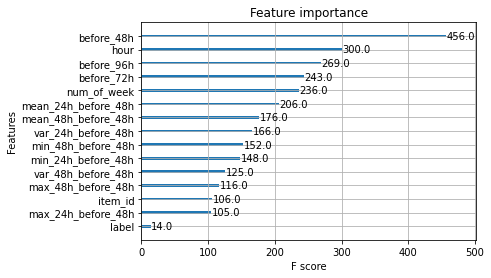

In [58]:
xgb.plot_importance(regressor)

## 6.推論（予測）
https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py

In [59]:
regressor.predict(test_x)

array([   21.547762,    21.547762,    21.547762, ..., 17873.158   ,
       17610.918   , 18028.18    ], dtype=float32)

In [60]:
test_x

,item_id,num_of_week,hour,before_48h,before_72h,before_96h,mean_24h_before_48h,var_24h_before_48h,max_24h_before_48h,min_24h_before_48h,mean_48h_before_48h,var_48h_before_48h,max_48h_before_48h,min_48h_before_48h,label
4343,0,1,0,1.269036,1.269036,1.586294,0.793147,2.450687e-01,1.586294,0.317259,1.011263,3.925742e-01,3.172589,0.317259,1
4344,0,1,1,1.269036,1.586294,1.269036,0.779928,2.273814e-01,1.586294,0.317259,1.011263,3.925742e-01,3.172589,0.317259,1
4345,0,1,2,1.269036,1.586294,1.586294,0.766709,2.093295e-01,1.586294,0.317259,1.004653,3.869080e-01,3.172589,0.317259,1
4346,0,1,3,1.269036,1.269036,1.586294,0.766709,2.093295e-01,1.586294,0.317259,0.998044,3.811526e-01,3.172589,0.317259,1
4347,0,1,4,1.269036,1.269036,1.586294,0.766709,2.093295e-01,1.586294,0.317259,0.991434,3.753079e-01,3.172589,0.317259,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624665,369,2,19,20540.540541,20675.675676,20243.243243,18716.216216,1.290294e+06,20540.540541,16486.486486,19105.855856,1.673331e+06,21810.810811,16486.486486,2
1624666,369,2,20,18972.972973,20027.027027,19243.243243,18672.297297,1.216443e+06,20540.540541,16486.486486,19100.225225,1.673273e+06,21810.810811,16486.486486,2
1624667,369,2,21,21432.432432,19878.378378,18864.864865,18737.049550,1.480055e+06,21432.432432,16486.486486,19153.716216,1.784900e+06,21810.810811,16486.486486,2
1624668,369,2,22,20540.540541,19770.270270,18635.135135,18769.144144,1.573982e+06,21432.432432,16486.486486,19193.412162,1.818490e+06,21810.810811,16486.486486,2


## 7.推論結果の可視化
client_21について  
正解データ  
Amazon Foreast  
xgboost  

In [61]:
df_xgb = pd.DataFrame(regressor.predict(test_x[test_x.item_id==21]), columns=['xgb'])

In [62]:
df_xgb

,xgb
0,21.547762
1,21.547762
2,21.547762
3,21.547762
4,21.547762
5,21.547762
6,21.547762
7,21.547762
8,21.547762
9,21.547762


In [63]:
df_y = pd.DataFrame(test_y[test_y.item_id==21]['demand'], columns=['demand']).reset_index(drop=True)

In [64]:
df_y

,demand
0,21.481943
1,19.302615
2,16.656289
3,16.033624
4,15.566625
5,16.344956
6,11.674969
7,11.052304
8,19.146949
9,45.143213


### Foreastの結果

In [65]:
df0 = pd.read_csv('../export_forecast_numbacktest_1/export_model1_20140701_20140702_2021-11-05T00-51-05Z_part0.csv')
df1 = pd.read_csv('../export_forecast_numbacktest_1/export_model1_20140701_20140702_2021-11-05T00-51-05Z_part1.csv')
df2 = pd.read_csv('../export_forecast_numbacktest_1/export_model1_20140701_20140702_2021-11-05T00-51-05Z_part2.csv')
df3 = pd.read_csv('../export_forecast_numbacktest_1/export_model1_20140701_20140702_2021-11-05T00-51-05Z_part3.csv')

In [66]:
df_forecast = pd.concat([df0,df1,df2,df3])

In [67]:
df_forecast['item_id'].unique()

array(['client_224', 'client_233', 'client_111', 'client_69',
       'client_121', 'client_150', 'client_335', 'client_65', 'client_40',
       'client_337', 'client_246', 'client_262', 'client_185',
       'client_229', 'client_256', 'client_348', 'client_135',
       'client_153', 'client_106', 'client_183', 'client_71',
       'client_319', 'client_101', 'client_286', 'client_132',
       'client_28', 'client_204', 'client_213', 'client_291',
       'client_343', 'client_311', 'client_225', 'client_178',
       'client_333', 'client_37', 'client_221', 'client_85', 'client_270',
       'client_126', 'client_164', 'client_125', 'client_304',
       'client_139', 'client_321', 'client_196', 'client_72', 'client_3',
       'client_52', 'client_352', 'client_48', 'client_331', 'client_60',
       'client_355', 'client_293', 'client_5', 'client_152', 'client_330',
       'client_217', 'client_296', 'client_245', 'client_341',
       'client_143', 'client_117', 'client_198', 'client_104',


In [68]:
df_result = df_forecast[df_forecast.item_id=='client_21'].reset_index(drop=True)

In [69]:
df_result

,item_id,date,p10,p50,p90
0,client_21,2014-07-01T00:00:00Z,19.166048,21.778353,23.937222
1,client_21,2014-07-01T01:00:00Z,16.131132,18.307056,20.588642
2,client_21,2014-07-01T02:00:00Z,14.010031,15.778008,17.750347
3,client_21,2014-07-01T03:00:00Z,13.835012,15.893695,17.614340
4,client_21,2014-07-01T04:00:00Z,13.765792,15.686901,17.802788
5,client_21,2014-07-01T05:00:00Z,14.773319,16.603321,19.548822
6,client_21,2014-07-01T06:00:00Z,10.852861,12.444874,14.222213
7,client_21,2014-07-01T07:00:00Z,7.900496,9.689272,11.803659
8,client_21,2014-07-01T08:00:00Z,14.899228,16.662745,18.136972
9,client_21,2014-07-01T09:00:00Z,28.941788,33.086403,37.724083


<AxesSubplot:xlabel='date'>

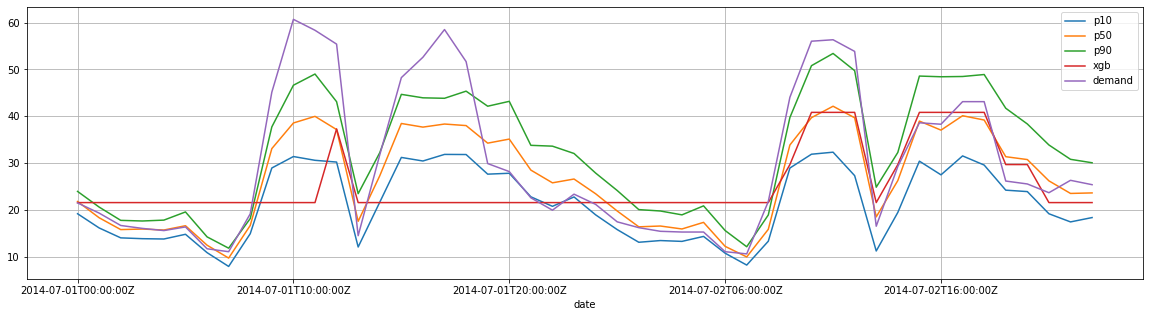

In [70]:
pd.concat([df_result, df_xgb, df_y], axis=1).plot(x='date',figsize=(20,5), grid=True)

# XGBoostの利点
特徴量の重要度がわかる

【デメリット】
コードのデバッグが大変
特徴量を作り込む必要あり
ハイパーパラメータのチューニング


<AxesSubplot:xlabel='date'>

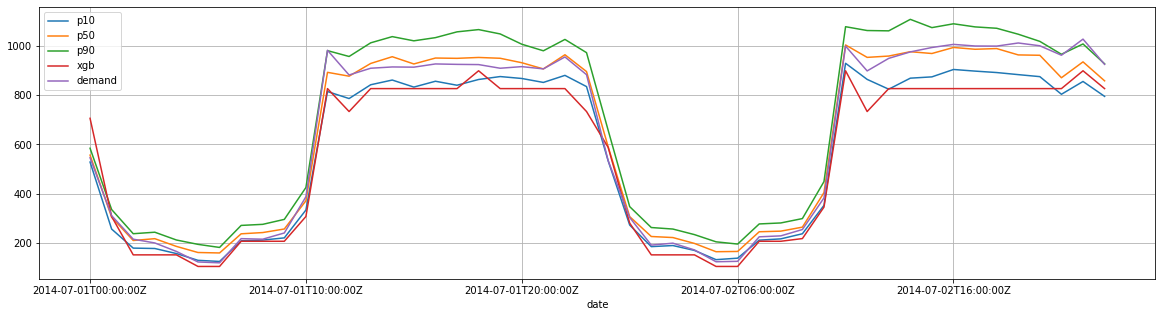

In [71]:
client_id = 100
df_xgb = pd.DataFrame(regressor.predict(test_x[test_x.item_id==client_id]), columns=['xgb'])
df_y = pd.DataFrame(test_y[test_y.item_id==client_id]['demand'], columns=['demand']).reset_index(drop=True)
df_result = df_forecast[df_forecast.item_id==f'client_{client_id}'].reset_index(drop=True)

pd.concat([df_result, df_xgb, df_y], axis=1).plot(x='date',figsize=(20,5), grid=True)

<AxesSubplot:xlabel='date'>

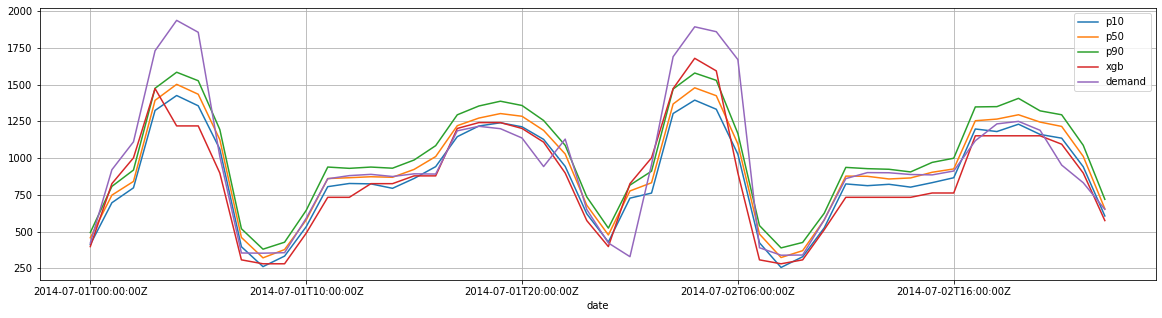

In [72]:
client_id = 101
df_xgb = pd.DataFrame(regressor.predict(test_x[test_x.item_id==client_id]), columns=['xgb'])
df_y = pd.DataFrame(test_y[test_y.item_id==client_id]['demand'], columns=['demand']).reset_index(drop=True)
df_result = df_forecast[df_forecast.item_id==f'client_{client_id}'].reset_index(drop=True)

pd.concat([df_result, df_xgb, df_y], axis=1).plot(x='date',figsize=(20,5), grid=True)

<AxesSubplot:xlabel='date'>

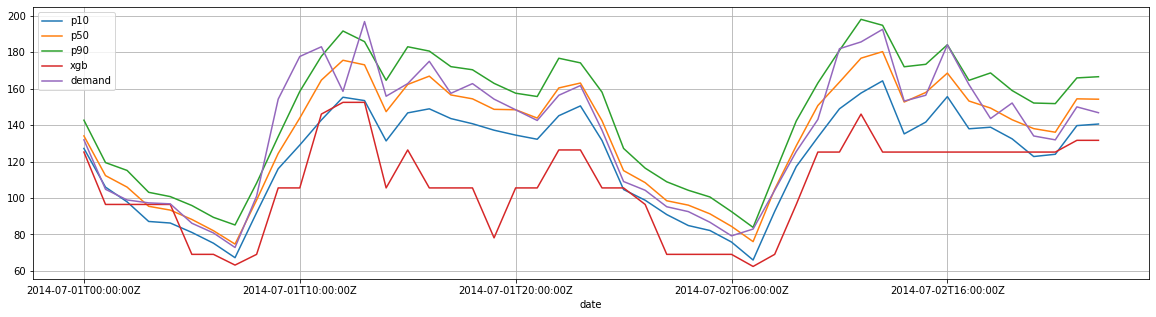

In [73]:
client_id = 11
df_xgb = pd.DataFrame(regressor.predict(test_x[test_x.item_id==client_id]), columns=['xgb'])
df_y = pd.DataFrame(test_y[test_y.item_id==client_id]['demand'], columns=['demand']).reset_index(drop=True)
df_result = df_forecast[df_forecast.item_id==f'client_{client_id}'].reset_index(drop=True)

pd.concat([df_result, df_xgb, df_y], axis=1).plot(x='date',figsize=(20,5), grid=True)

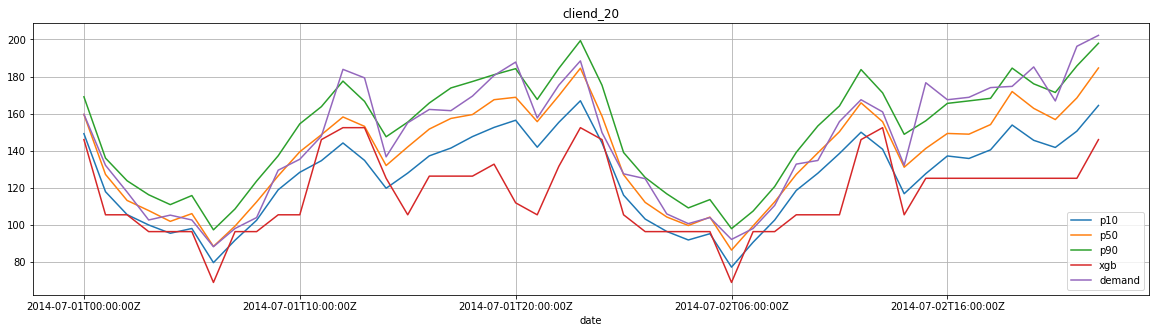

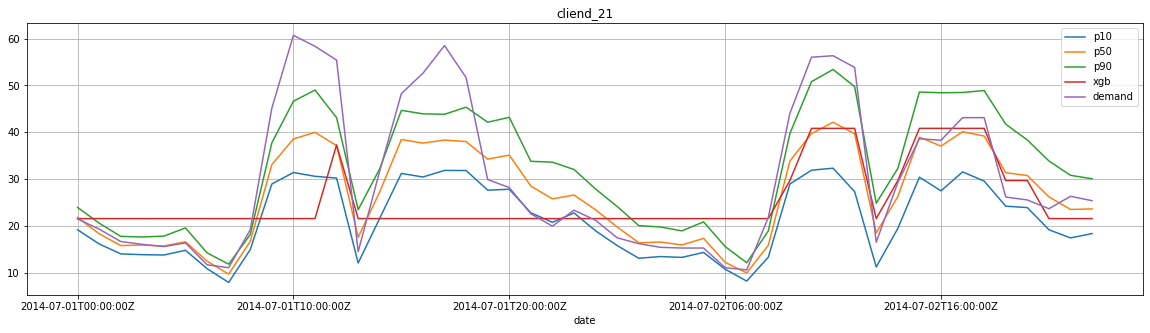

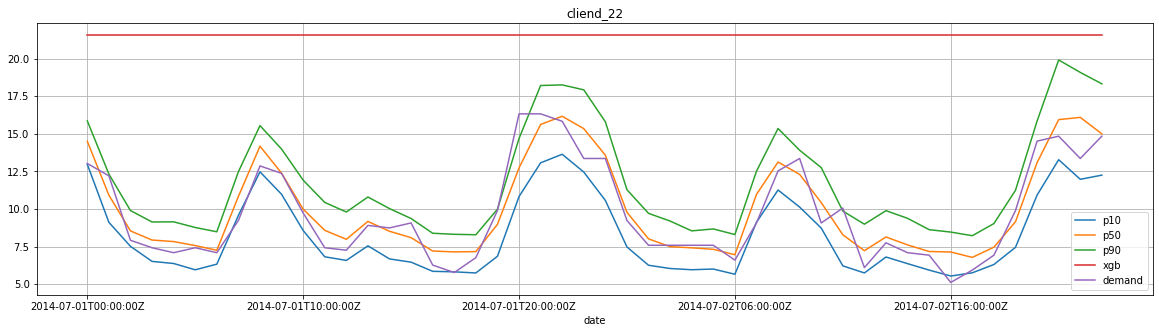

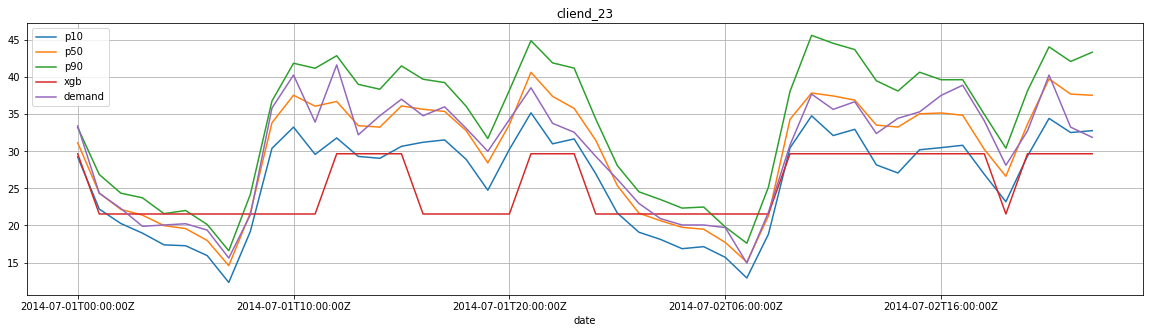

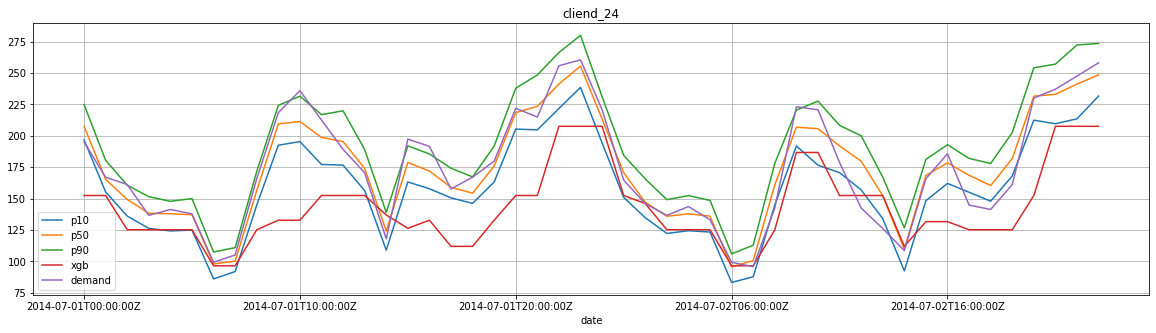

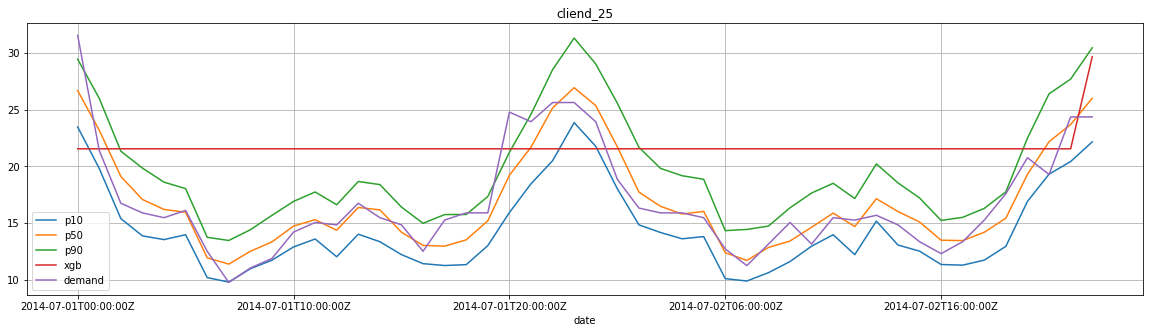

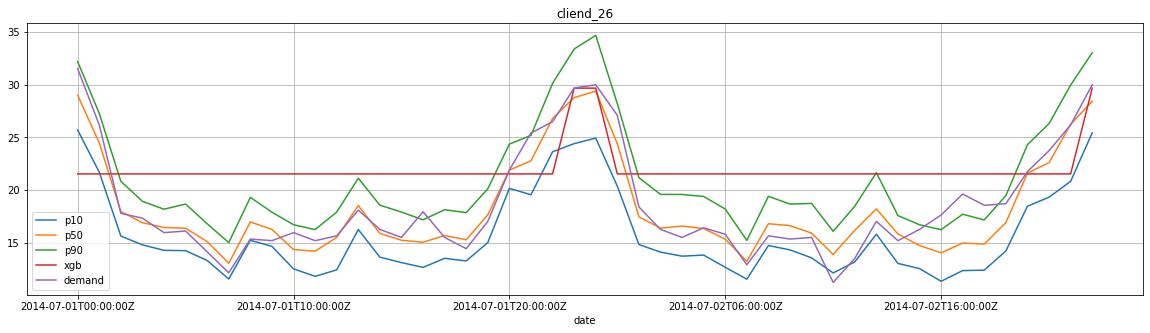

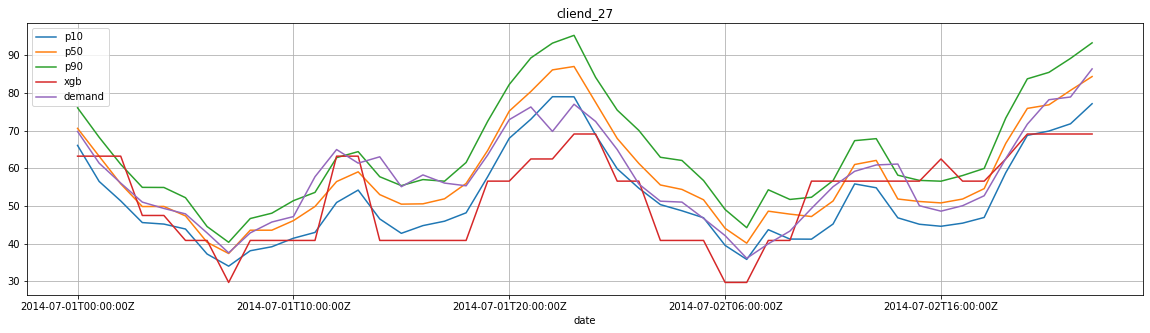

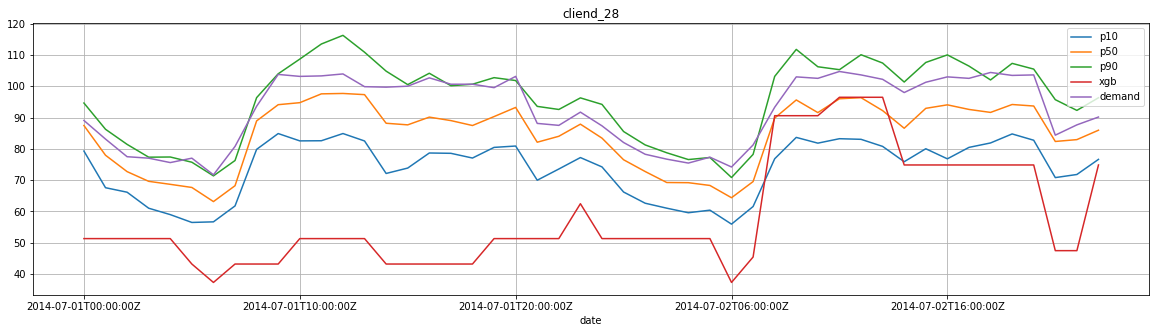

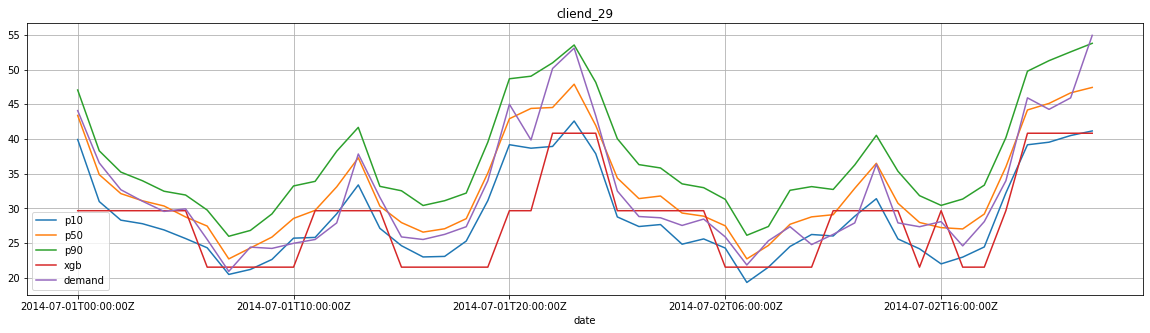

In [76]:
for client_id in range(20,30):
    df_xgb = pd.DataFrame(regressor.predict(test_x[test_x.item_id==client_id]), columns=['xgb'])
    df_y = pd.DataFrame(test_y[test_y.item_id==client_id]['demand'], columns=['demand']).reset_index(drop=True)
    df_result = df_forecast[df_forecast.item_id==f'client_{client_id}'].reset_index(drop=True)

    pd.concat([df_result, df_xgb, df_y], axis=1).plot(x='date',figsize=(20,5), grid=True,title=f'cliend_{client_id}')